# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


**Answer:** 
The primary business objective of this project is to analyze key housing features that influence property values and to build predictive models that can forecast housing prices accurately. For stakeholders like real estate investors, buyers, and developers, understanding the relationship between square footage, number of rooms, bathrooms, and other amenities is essential for making data-driven decisions. 

**1.2:**  How will your solution be used?


**Answer:** The solution will help real estate agents, buyers, and investors make informed decisions by identifying key factors that influence housing prices. It can guide pricing strategies, highlight high-value property features, and support automated price estimation on real estate platforms.

**1.3:**  How should success (or failure) be measured?


**Answer:** Success could be measured by the model’s ability to accurately predict housing prices using unseen test data. Besides RMSE, success in a housing price prediction project can also be measured by analysing business impact - Are realtors or investors making better decisions using the model? 

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [3]:
# data sample
pd.set_option('display.max_columns', None)
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [ ]:
# show name and type of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [24]:
df.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,assessmentyear,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
count,7.761300e+04,25007.000000,207.000000,50.000000,77579.000000,77579.000000,15.000000,49809.000000,76963.000000,614.0,6037.000000,77378.000000,73923.000000,42.000000,3027.000000,6037.000000,386.000000,77579.000000,8289.000000,76963.000000,25520.000000,25520.000000,49571.000000,7.757900e+04,7.757900e+04,6.932100e+04,16174.0,869.000000,465.0,1074.0,15079.0,77579.000000,7.757900e+04,76107.000000,77579.000000,30974.000000,77529.000000,77579.000000,50.0,10106.000000,223.000000,50703.000000,2393.000000,70.000000,77309.000000,17599.000000,77579.0,2900.000000,7.733200e+04,7.757800e+04
mean,1.300781e+07,1.812013,7.386473,679.720000,2.298496,3.053223,3.933333,6.533779,2.316392,66.0,1366.165314,1784.935421,1760.284553,1388.761905,2354.491245,1381.388935,2082.500000,6048.814151,1.191217,2.250107,1.815282,350.047061,3.921749,3.400837e+07,-1.182037e+08,2.997344e+04,1.0,517.930955,1.0,1.0,1.0,261.824476,6.049124e+07,33683.055107,2534.514933,187725.110544,96586.692812,1.476276,7.0,1.009598,6.040359,1.110309,305.460928,216.385714,1968.611507,1.434286,2016.0,14.088276,6.049667e+13,4.901506e+05
std,3.518717e+06,2.965768,2.728030,689.703546,0.996732,1.140480,0.258199,1.722062,0.979689,0.0,670.701336,954.250373,934.352566,122.220874,1186.985442,725.792665,1240.382784,20.747252,0.490980,0.966492,0.588340,261.646070,3.594780,2.652873e+05,3.594085e+05,1.233050e+05,0.0,156.569664,0.0,0.0,0.0,5.141596,2.058962e+05,47211.780350,801.447913,165045.086058,3793.552065,2.823686,0.0,0.118572,0.556035,1.169967,238.735241,190.177514,23.793171,0.544515,0.0,2.181281,1.533339e+12,6.537979e+05
min,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,44.000000,128.000000,128.000000,1056.000000,598.000000,44.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.000000,3.333953e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,2016.0,3.000000,6.037101e+13,1.000000e+03
25%,1.153821e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,955.000000,1182.000000,1172.000000,1344.000000,1624.000000,956.000000,993.750000,6037.000000,1.000000,2.000000,2.000000,0.000000,2.000000,3.381463e+07,-1.184150e+08,5.700000e+03,1.0,424.000000,1.0,1.0,1.0,261.000000,6.037311e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,2016.0,14.000000,6.037311e+13,2.068985e+05
50%,1.253004e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,1257.000000,1542.000000,1523.000000,1440.000000,2088.000000,1259.000000,1812.500000,6037.000000,1.000000,2.000000,2.000000,436.000000,2.000000,3.402200e+07,-1.181810e+08,7.206000e+03,1.0,500.000000,1.0,1.0,1.0,261.000000,6.037603e+07,25218.000000,3101.000000,118849.000000,96389.000000,0.000000,7.0,1.000000,6.000000,1.000000,250.000000,164.500000,1970.000000,1.000000,2016.0,15.000000,6.037603e+13,3.588785e+05
75%,1.421101e+07,1.000000,7.000000,796.500000,3.000000,4.000000,4.000000,8.000000,3.000000,66.0,1615.000000

#### Target column profiling

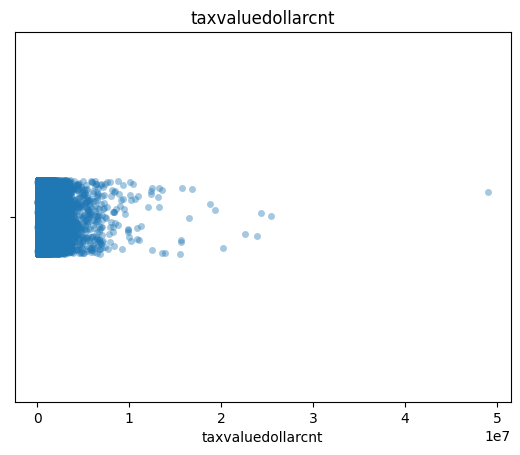

In [ ]:
sns.stripplot(x=df['taxvaluedollarcnt'], jitter=True, size=5, alpha=0.4)
plt.title('taxvaluedollarcnt')
plt.show()

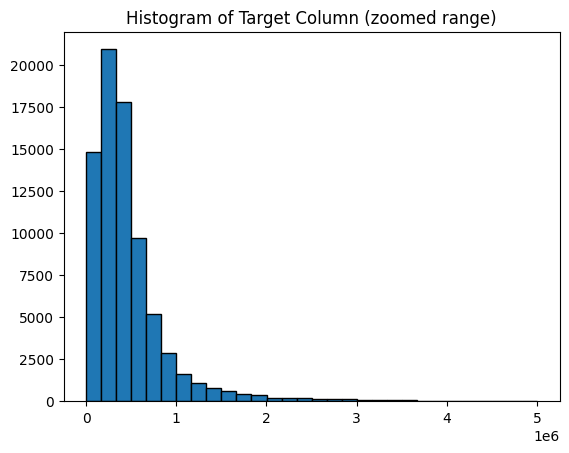

In [ ]:
# zoomed-in region
lower_bound, upper_bound = 0, 0.5*1e7

filtered_data = df[(df['taxvaluedollarcnt'] >= lower_bound) & (df['taxvaluedollarcnt'] <= upper_bound)]['taxvaluedollarcnt']

plt.hist(filtered_data, bins=30, edgecolor='black')
plt.title('Histogram of Target Column (zoomed range)')
plt.show()

In [ ]:
# % of missing values of all columns
na_count = df.isna().sum()  
total_records = len(df)  

na_percentage = (na_count / total_records) * 100 
na_percentage

parcelid                         0.000000
airconditioningtypeid           67.779882
architecturalstyletypeid        99.733292
basementsqft                    99.935578
bathroomcnt                      0.043807
bedroomcnt                       0.043807
buildingclasstypeid             99.980673
buildingqualitytypeid           35.823895
calculatedbathnbr                0.837489
decktypeid                      99.208895
finishedfloor1squarefeet        92.221664
calculatedfinishedsquarefeet     0.302784
finishedsquarefeet12             4.754358
finishedsquarefeet13            99.945885
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedsquarefeet6             99.502661
fips                             0.043807
fireplacecnt                    89.320088
fullbathcnt                      0.837489
garagecarcnt                    67.118910
garagetotalsqft                 67.118910
hashottuborspa                  98.017085
heatingorsystemtypeid           36

In [5]:
# show columns that has more than 50% missing values
na_percentage_filtered = na_percentage[na_percentage > 50]
na_percentage_filtered

airconditioningtypeid       67.779882
architecturalstyletypeid    99.733292
basementsqft                99.935578
buildingclasstypeid         99.980673
decktypeid                  99.208895
finishedfloor1squarefeet    92.221664
finishedsquarefeet13        99.945885
finishedsquarefeet15        96.099880
finishedsquarefeet50        92.221664
finishedsquarefeet6         99.502661
fireplacecnt                89.320088
garagecarcnt                67.118910
garagetotalsqft             67.118910
hashottuborspa              98.017085
poolcnt                     79.160708
poolsizesum                 98.880342
pooltypeid10                99.400874
pooltypeid2                 98.616211
pooltypeid7                 80.571554
regionidneighborhood        60.091737
storytypeid                 99.935578
threequarterbathnbr         86.978985
typeconstructiontypeid      99.712677
yardbuildingsqft17          96.916754
yardbuildingsqft26          99.909809
numberofstories             77.324675
fireplacefla

In [7]:
len(na_percentage_filtered)

29

In [ ]:
# only count unique values for categorical columns
df.select_dtypes(exclude=['number']).nunique()

hashottuborspa                  1
propertycountylandusecode      75
propertyzoningdesc           1907
fireplaceflag                   1
taxdelinquencyflag              1
dtype: int64

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

**Answer:**
- hashottuborspa 
- propertycountylandusecode
- propertyzoningdesc
- fireplaceflag
- taxdelinquencyflag

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

**Answer:** All the columns related to "ID" are useless at first glance, they are in the numerical format but their values do not carry meaningful numerical information or have logical relationships with the target variable. They serve only as unique identifiers within the business context. For example. "parcelid" is used to identiy land parcels but it does not contain any numerical or predictive value related to property characteristics or pricing.

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

**Answer:** There are 29 features appear to be useless since they have more than 50% of missing values. For example, column "storytypeid" has 99.9% missing values.

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

**Answer:** Categorical columns "propertyzoningdesc" and "propertycountylandusecode" with 1907 and 75 unique values respectively, which are too large for useful analysis.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

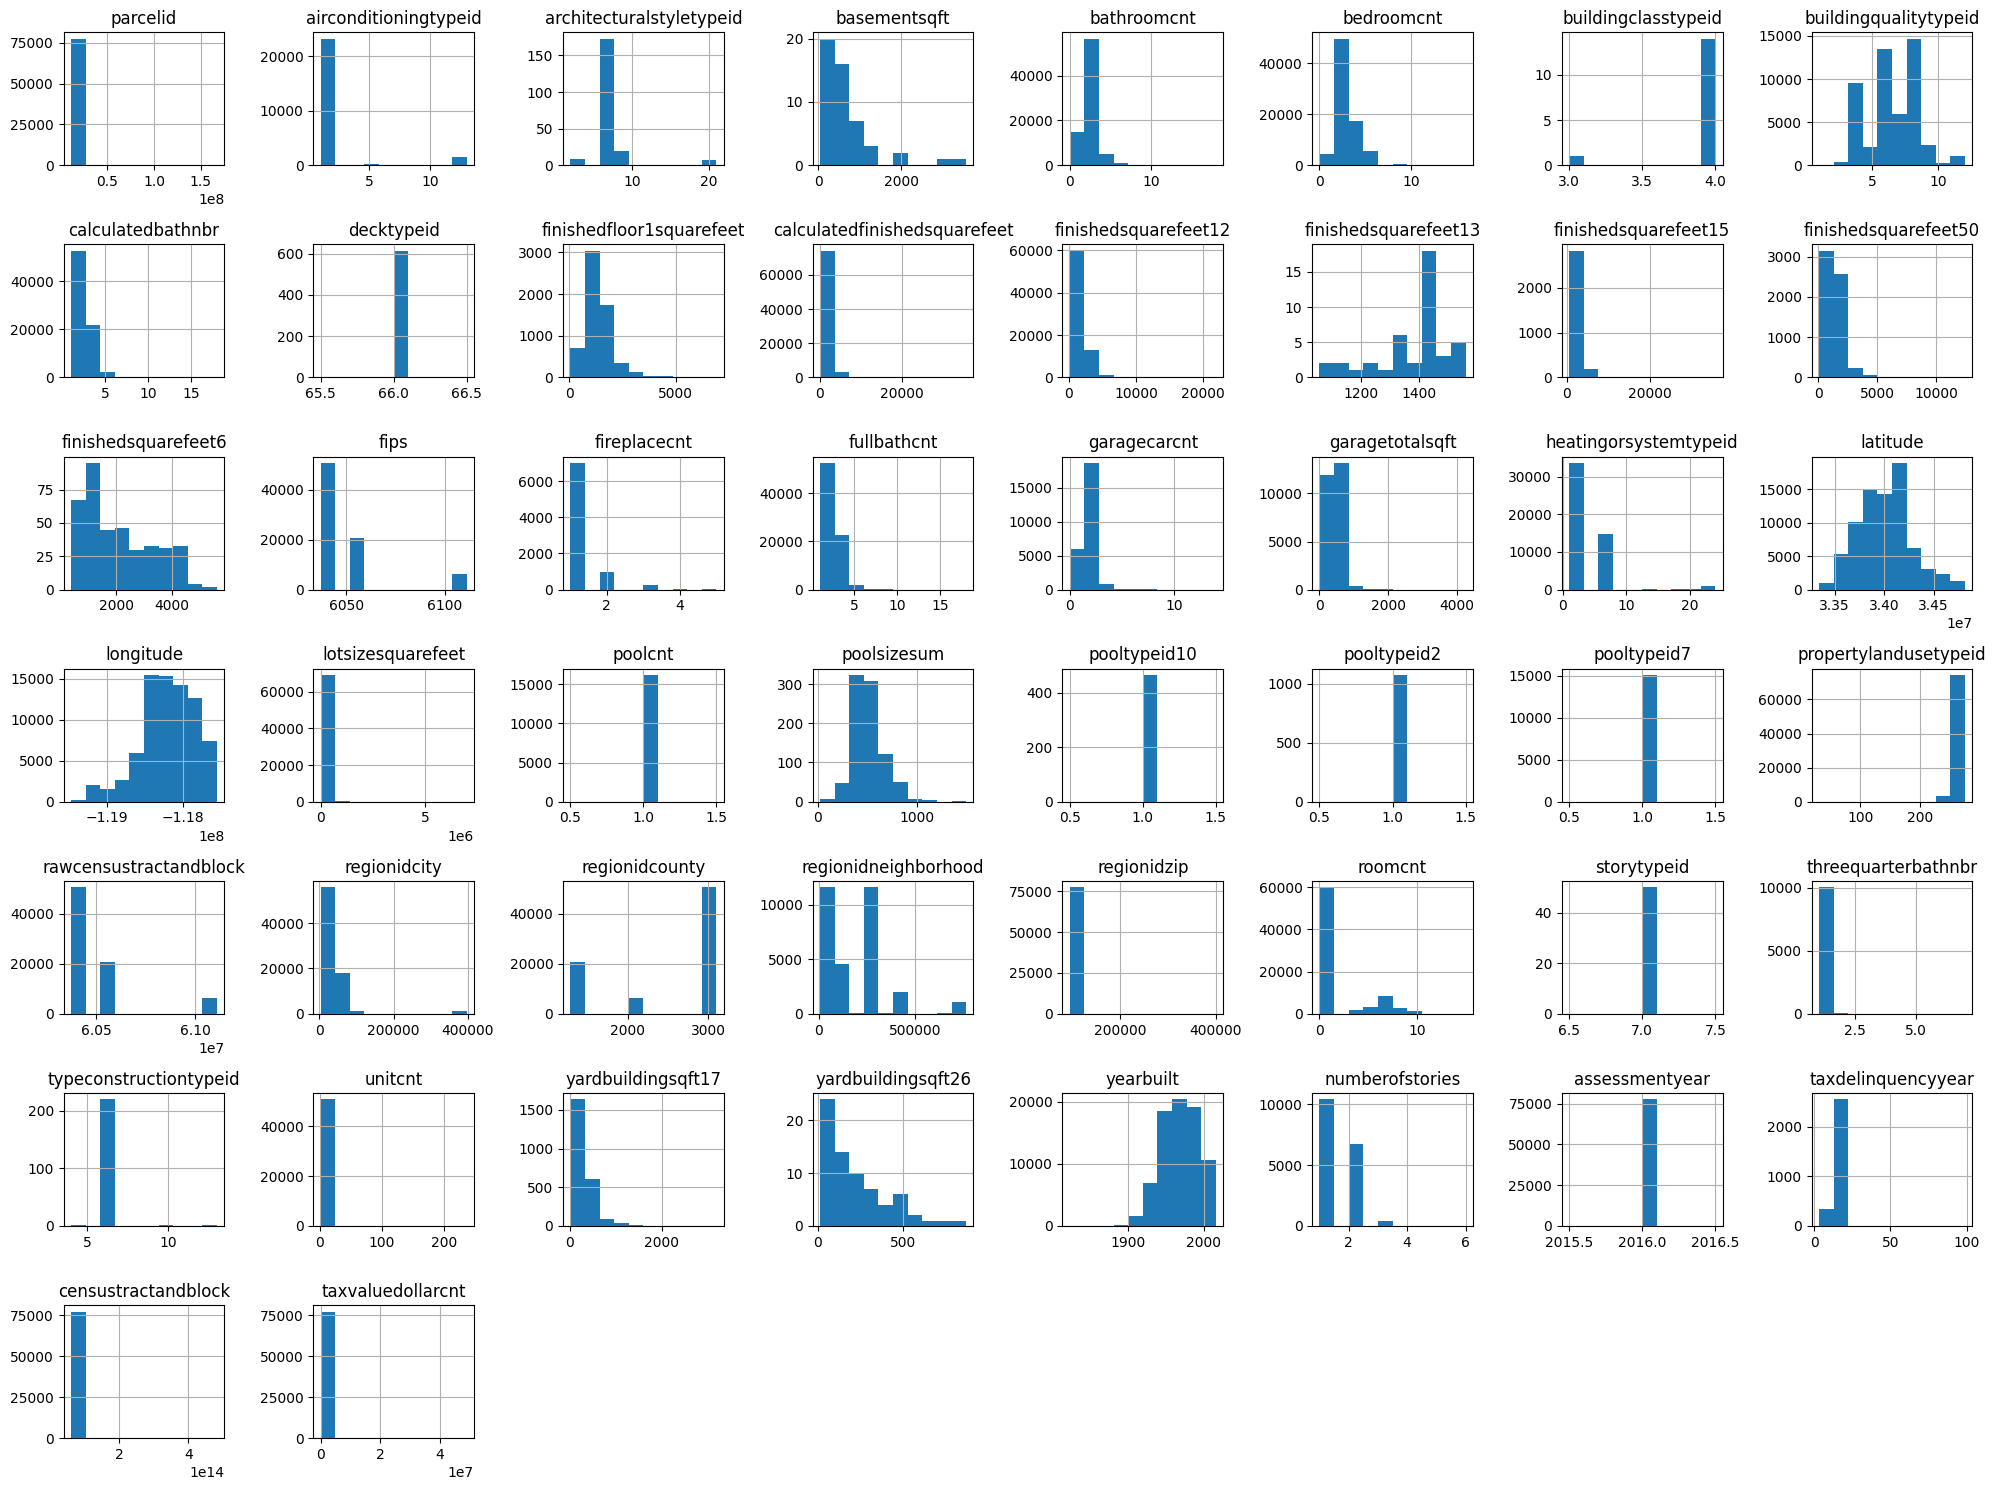

In [ ]:
# histograms for all features

df.hist(figsize=(20, 15), layout=(-1, 8))
plt.tight_layout()

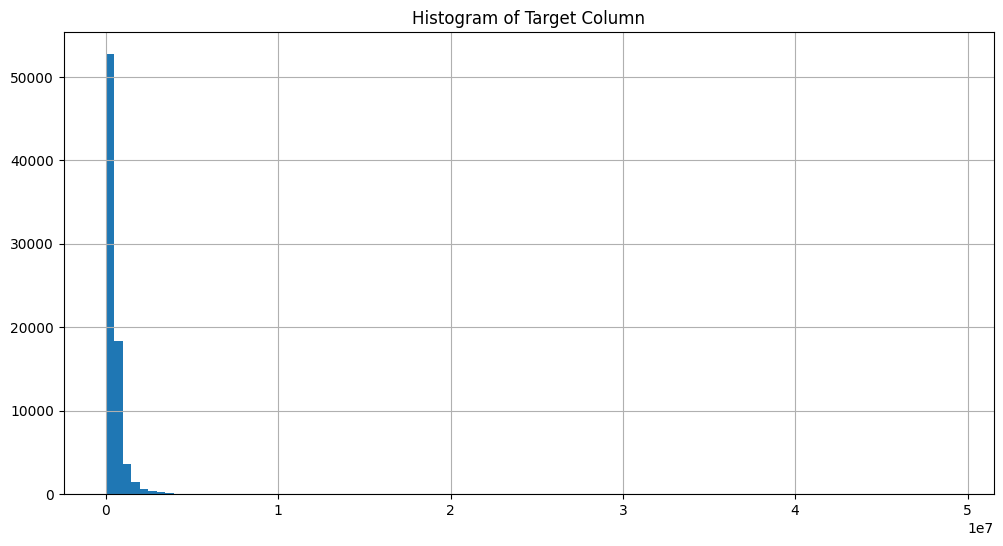

In [30]:
# individual plot for target variable
plt.figure(figsize=(12, 6))  
df["taxvaluedollarcnt"].hist(bins=100)
plt.title('Histogram of Target Column')
plt.show()


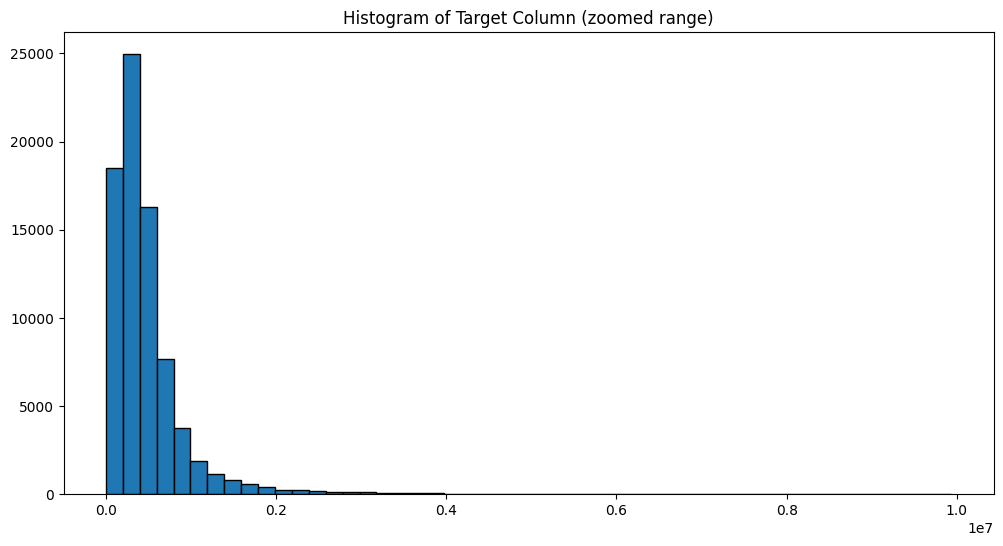

In [32]:
# zoomed-in region
lower_bound, upper_bound = 0, 1*1e7

filtered_data = df[(df['taxvaluedollarcnt'] >= lower_bound) & (df['taxvaluedollarcnt'] <= upper_bound)]['taxvaluedollarcnt']
plt.figure(figsize=(12, 6))  
plt.hist(filtered_data, bins=50, edgecolor='black')
plt.title('Histogram of Target Column (zoomed range)')
plt.show()

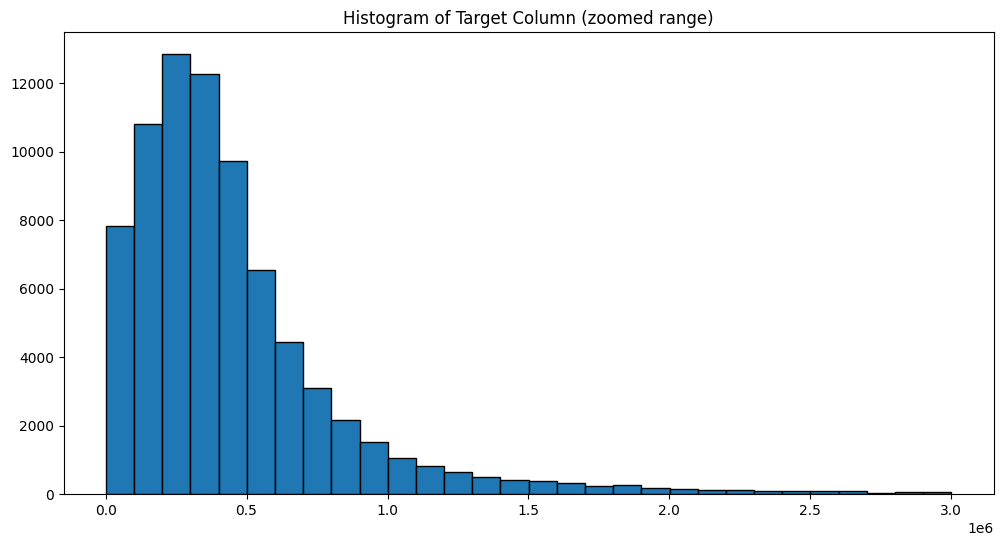

In [33]:
# zoomed-in region
lower_bound, upper_bound = 0, 0.3*1e7

filtered_data = df[(df['taxvaluedollarcnt'] >= lower_bound) & (df['taxvaluedollarcnt'] <= upper_bound)]['taxvaluedollarcnt']
plt.figure(figsize=(12, 6))  
plt.hist(filtered_data, bins=30, edgecolor='black')
plt.title('Histogram of Target Column (zoomed range)')
plt.show()

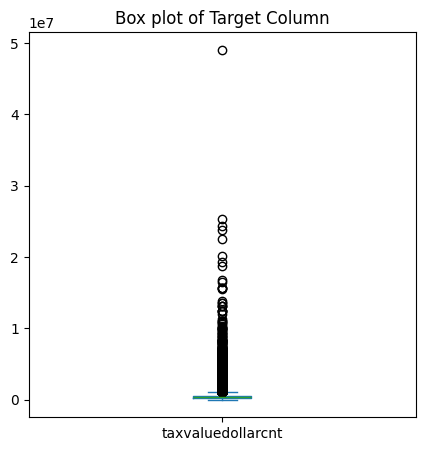

In [53]:
# box plot
plt.figure(figsize=(5, 5))
df['taxvaluedollarcnt'].plot.box()
plt.title('Box plot of Target Column')
plt.show()

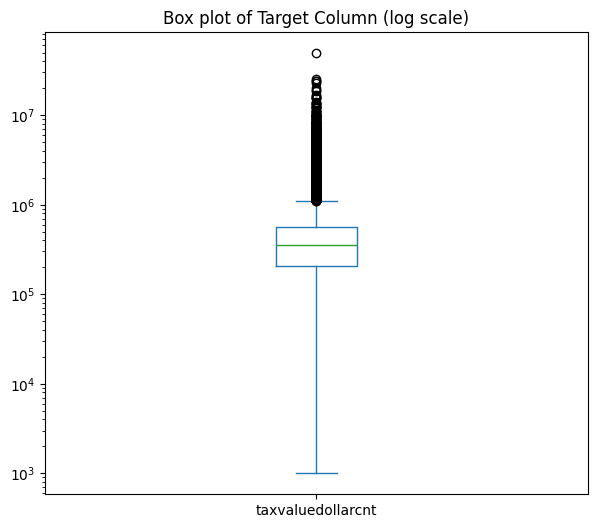

In [56]:
# box plot log scale
plt.figure(figsize=(7, 6))
df['taxvaluedollarcnt'].plot.box()
plt.title('Box plot of Target Column (log scale)')
plt.yscale("log")
plt.show()

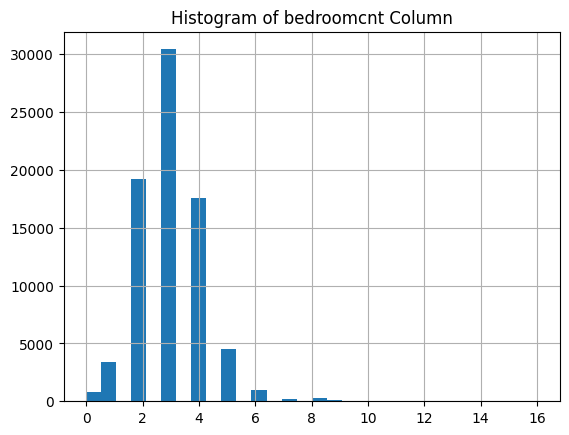

In [ ]:
# histogram for bedroomcnt
df["bedroomcnt"].hist(bins=30)
plt.title('Histogram of bedroomcnt Column')
plt.show()

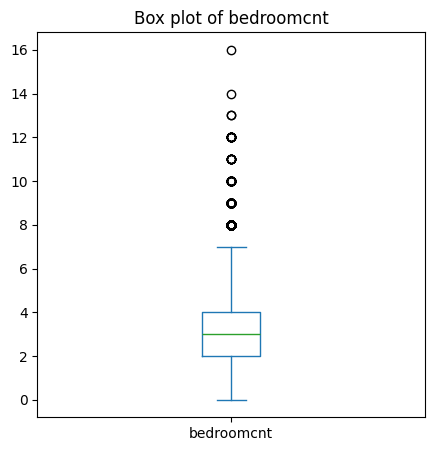

In [58]:
# box plot for bedroomcnt
plt.figure(figsize=(5, 5))
df['bedroomcnt'].plot.box()
plt.title('Box plot of bedroomcnt')
plt.show()

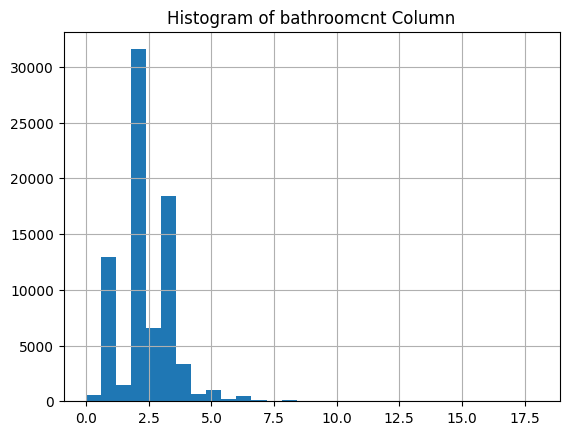

In [ ]:
# histogram for bathroomcnt
df["bathroomcnt"].hist(bins=30)
plt.title('Histogram of bathroomcnt Column')
plt.show()

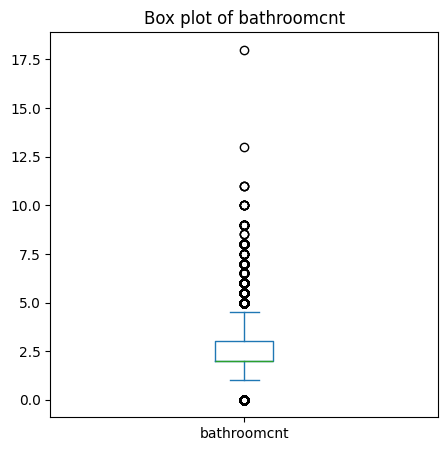

In [62]:
# box plot for bathroomcnt
plt.figure(figsize=(5, 5))
df['bathroomcnt'].plot.box()
plt.title('Box plot of bathroomcnt')
plt.show()

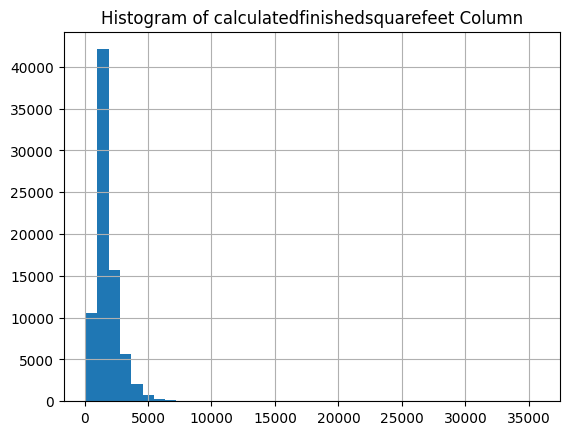

In [69]:
# histogram for calculatedfinishedsquarefeet
df["calculatedfinishedsquarefeet"].hist(bins=40)
plt.title('Histogram of calculatedfinishedsquarefeet Column')
plt.show()

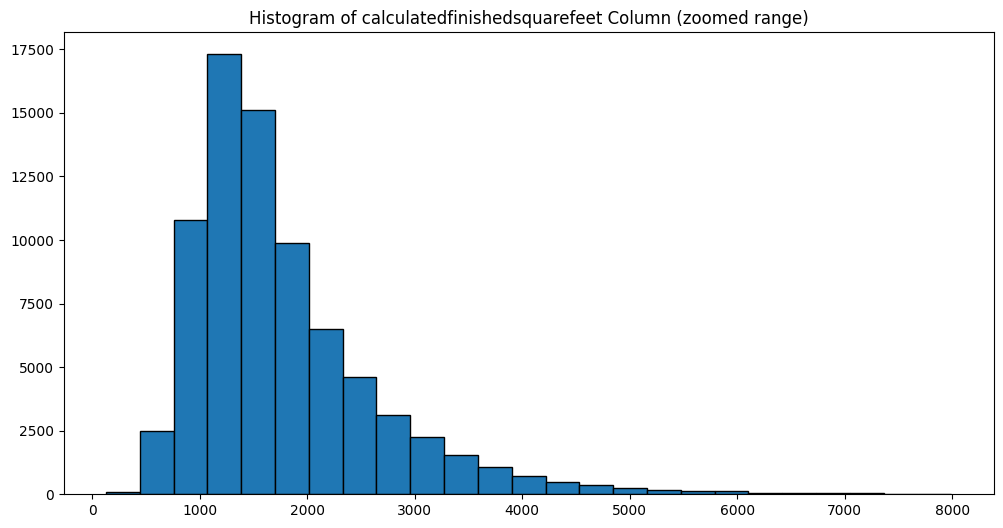

In [74]:
# zoomed-in region
lower_bound, upper_bound = 0, 8000

filtered_data = df[(df['calculatedfinishedsquarefeet'] >= lower_bound) & (df['calculatedfinishedsquarefeet'] <= upper_bound)]['calculatedfinishedsquarefeet']
plt.figure(figsize=(12, 6))  
plt.hist(filtered_data, bins=25, edgecolor='black')
plt.title('Histogram of calculatedfinishedsquarefeet Column (zoomed range)')
plt.show()

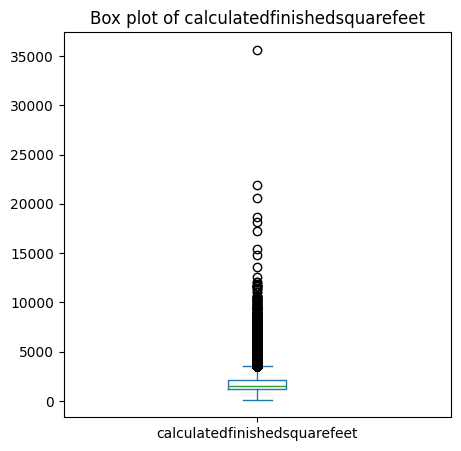

In [78]:
# box plot for calculatedfinishedsquarefeet
plt.figure(figsize=(5, 5))
df['calculatedfinishedsquarefeet'].plot.box()
plt.title('Box plot of calculatedfinishedsquarefeet')
plt.show()

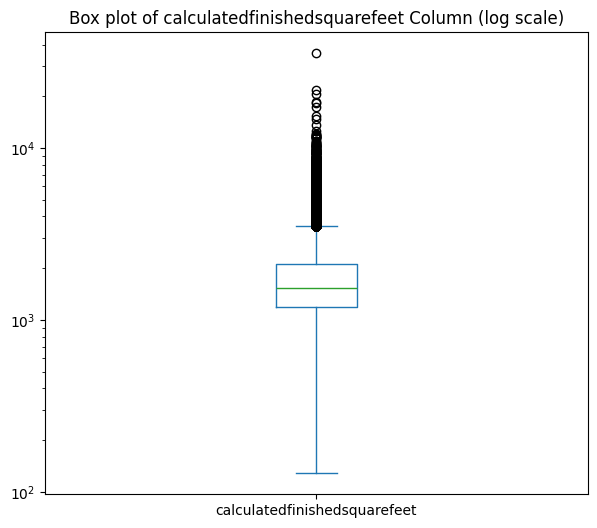

In [79]:
# box plot log scale
plt.figure(figsize=(7, 6))
df['calculatedfinishedsquarefeet'].plot.box()
plt.title('Box plot of calculatedfinishedsquarefeet Column (log scale)')
plt.yscale("log")
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


**Answer:**
Target variable("taxvaluedollarcnt") and 3 interesting features: "bedroomcnt", "bathroomcnt" and "calculatedfinishedsquarefeet" are examined in this part
The distributions of all 4 examined features are right-skewed. "taxvaluedollarcnt" and "calculatedfinishedsquarefeet" has excessive amount of outliers with large values while "bedroomcnt" has a lot of outliers with large values and "bathroomcnt" has some outliers with large values. "taxvaluedollarcnt" and "calculatedfinishedsquarefeet" are extremely right-skewed that needed to be zoomed in to get more details in the peak region. These columns were chosen due to their inherent business value, as they represent key characteristics of real estate properties that have a strong relationship with assessed value of the property(target variable) in a business context.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [3]:
# drop ID-related columns
df_1 = df.drop(columns=[col for col in df.columns if col.endswith('id')])
df_1.columns

Index(['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'assessmentyear',
       'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock',
       'taxvaluedollarcnt'],
      dtype='object')

In [4]:
# further drop some ID-related columns
df_1 = df_1.drop(columns=["pooltypeid10","pooltypeid2","pooltypeid7","fips","censustractandblock"])
df_1.columns

Index(['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'assessmentyear',
       'taxdelinquencyflag', 'taxdelinquencyyear', 'taxvaluedollarcnt'],
      dtype='object')

In [5]:
# drop columns with consistent values
df_1 = df_1.drop(columns=["assessmentyear"])
df_1.columns

Index(['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'taxvaluedollarcnt'],
      dtype='object')

In [6]:
# drop categorical features with too many distinct values
df_2 = df_1.drop(columns=["propertycountylandusecode","propertyzoningdesc"])
df_2.columns

Index(['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'taxvaluedollarcnt'],
      dtype='object')

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [7]:
# investigate each feature having over 50% missing values
na_count = df_2.isna().sum()  
total_records = len(df_2)  

na_percentage = (na_count / total_records) * 100 
na_percentage_filtered = na_percentage[na_percentage > 50]
for i, x in na_percentage_filtered.items(): 
    print(f"{i}: {df[i].unique()}")

basementsqft: [  nan  900. 1416.  224.  100.  512.  380.  204.  515.  273.  200.   90.
 3112.  405.  674. 1252.  912.  254. 3560.  352.  168.  394. 1218.  300.
  280.  800.  600.  700.  640.  819. 1809.  604.  126.  588.  314.  669.
  786.  396.  112.  645.  384. 1969.  252.   38.]
finishedfloor1squarefeet: [  nan 1465.  842. ... 5774.  943. 2652.]
finishedsquarefeet13: [  nan 1440. 1344. 1152. 1536. 1392. 1056. 1248. 1300. 1560. 1488. 1512.
 1060. 1200.]
finishedsquarefeet15: [  nan 3435. 3626. ... 4175. 1228. 4422.]
finishedsquarefeet50: [  nan 1465.  842. ... 5774.  943. 2652.]
finishedsquarefeet6: [  nan 2482.  624. 4198. 5041. 1482.  750. 1132. 4468. 1235.  520. 4380.
  908.  600. 2792. 2298. 2515. 1950. 1360.  856.  688.  634. 4109.  938.
 4414.  956. 2635. 1012. 2030. 1792. 4086. 1517.  989. 1214.  784. 4302.
 3280.  811.  952. 1652. 3462. 3709. 2470.  964.  837. 3829. 1242. 1220.
 3001. 1832. 1380. 1320. 3169.  845. 3500. 3423. 4411. 1085. 4233.  940.
 1498.  826. 2625. 2445. 2

In [8]:
# exception column list from previous investigation, they only have 2 unique values and one of them is Nan.
ex_list = [
    'hashottuborspa',
    'poolcnt',
    'fireplaceflag',
    'taxdelinquencyflag'
]
for col in ex_list:
    print(f"{col} value counts:")
    print(df_2[col].value_counts(dropna=False))
    print()

hashottuborspa value counts:
hashottuborspa
NaN     76074
True     1539
Name: count, dtype: int64

poolcnt value counts:
poolcnt
NaN    61439
1.0    16174
Name: count, dtype: int64

fireplaceflag value counts:
fireplaceflag
NaN     77441
True      172
Name: count, dtype: int64

taxdelinquencyflag value counts:
taxdelinquencyflag
NaN    74713
Y       2900
Name: count, dtype: int64



In [9]:
# drop columns with over 50% missing values (with exceptions)
na_count = df_2.isna().sum()  
total_records = len(df_2)  

na_percentage = (na_count / total_records) * 100 
drop_col = na_percentage[na_percentage > 50].index
drop_col2 = drop_col.difference(ex_list)
df_3 = df_2.drop(columns=drop_col2)
df_3.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt',
       'hashottuborspa', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt', 'fireplaceflag',
       'taxdelinquencyflag', 'taxvaluedollarcnt'],
      dtype='object')

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



**Answer:** features with over 50% missing values are dropped, except for the ones that has only one value other than the null value.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [10]:
# Count null values / row
na_count_row = df_3.isna().sum(axis=1)
na_count_percent = (na_count_row / df_3.shape[1]) * 100
drop_row = df_3[na_count_percent > 50]
len(drop_row)

120

In [13]:
len(df_3)

77613

In [11]:
# drop rows that has over 50% null values
df_4 = drop_row = df_3[na_count_percent <= 50]
len(df_4)

77493

In [12]:
# drop rows that has null value in the target variable
df_5 = df_4.dropna(subset=['taxvaluedollarcnt'])
len(df_5)

77492

In [13]:
# drop 10% of the data that is outliers in the target variable
# only drop large values since the target varaibles is highly right-skewed

upper_bound = df['taxvaluedollarcnt'].quantile(0.9)

df_6 = df_5[df_5['taxvaluedollarcnt'] <= upper_bound]
len(df_6)

69742

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


**Answer:** samples with over 50% missing values (across the row) are dropped, samples that has null values in the target variable are dropped, samples that are outliers(top 10 percentile of the whole data) of the target variable are dropped. the top 10 percentile is used due the extreme skewness in the target variable.


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [14]:
# overview of the null values
na_count = df_6.isna().sum()  
total_records = len(df_6)  

na_percentage = (na_count / total_records) * 100 
na_percentage

bathroomcnt                      0.000000
bedroomcnt                       0.000000
calculatedbathnbr                0.603653
calculatedfinishedsquarefeet     0.093201
finishedsquarefeet12             4.548192
fullbathcnt                      0.603653
hashottuborspa                  98.824238
latitude                         0.000000
longitude                        0.000000
lotsizesquarefeet               11.195549
poolcnt                         81.325457
rawcensustractandblock           0.000000
regionidcity                     1.881219
regionidcounty                   0.000000
regionidzip                      0.043016
roomcnt                          0.000000
unitcnt                         34.310745
yearbuilt                        0.184967
fireplaceflag                   99.761980
taxdelinquencyflag              96.277709
taxvaluedollarcnt                0.000000
dtype: float64

In [15]:
# drop if missing value <5%
drop_na= na_percentage[na_percentage < 5].index
df_7 = df_6.dropna(subset=drop_na)
len(df_7)

65137

In [19]:
len(df_6)

69742

In [16]:
na_count = df_7.isna().sum()  
total_records = len(df_7)  

na_percentage = (na_count / total_records) * 100 
na_percentage

bathroomcnt                      0.000000
bedroomcnt                       0.000000
calculatedbathnbr                0.000000
calculatedfinishedsquarefeet     0.000000
finishedsquarefeet12             0.000000
fullbathcnt                      0.000000
hashottuborspa                  98.804059
latitude                         0.000000
longitude                        0.000000
lotsizesquarefeet               11.759829
poolcnt                         80.501098
rawcensustractandblock           0.000000
regionidcity                     0.000000
regionidcounty                   0.000000
regionidzip                      0.000000
roomcnt                          0.000000
unitcnt                         35.766154
yearbuilt                        0.000000
fireplaceflag                   99.746688
taxdelinquencyflag              96.450558
taxvaluedollarcnt                0.000000
dtype: float64

<Axes: >

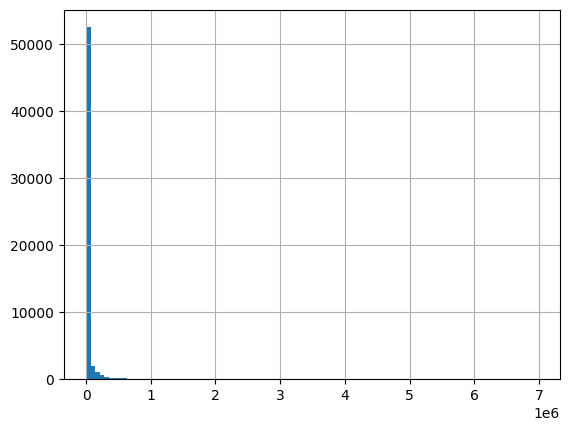

In [21]:
df_7["lotsizesquarefeet"].hist(bins=100)

<Axes: >

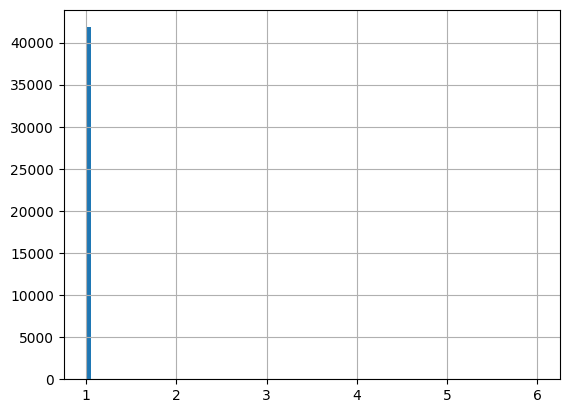

In [22]:
df_7["unitcnt"].hist(bins=100)


<Axes: >

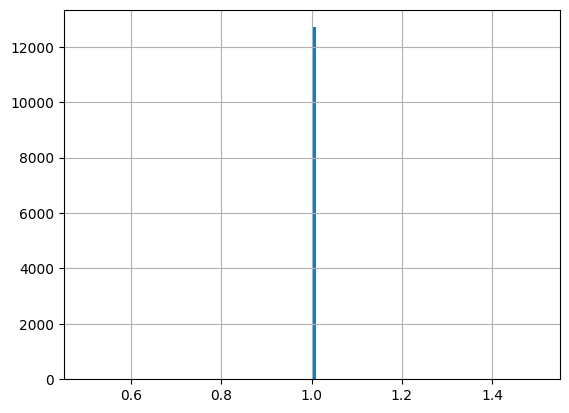

In [23]:
df_7["poolcnt"].hist(bins=100)

In [24]:
print(df_7["poolcnt"].value_counts(dropna=False))

poolcnt
NaN    52436
1.0    12701
Name: count, dtype: int64


In [17]:
# median imputation for skewed numerical data
df_8=df_7.copy()
df_8['lotsizesquarefeet'] = df_8['lotsizesquarefeet'].fillna(df_8['lotsizesquarefeet'].median())
df_8['unitcnt'] = df_8['unitcnt'].fillna(df_8['unitcnt'].median())
# poolcnt only has one value, set null value as 0 to distinguish
df_8['poolcnt'] = df_8['poolcnt'].fillna(0)
df_8.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,hashottuborspa,latitude,longitude,lotsizesquarefeet,...,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,fireplaceflag,taxdelinquencyflag,taxvaluedollarcnt
1,1.0,2.0,1.0,1465.0,1465.0,1.0,NaN,34449266.0,-119281531.0,12647.0,...,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,NaN,NaN,464000.0
2,2.0,3.0,2.0,1243.0,1243.0,2.0,NaN,33886168.0,-117823170.0,8432.0,...,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,NaN,NaN,564778.0
3,3.0,4.0,3.0,2376.0,2376.0,3.0,NaN,34245180.0,-118240722.0,13038.0,...,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,NaN,NaN,145143.0
4,3.0,3.0,3.0,1312.0,1312.0,3.0,NaN,34185120.0,-118414640.0,278581.0,...,6.037124e+07,12447.0,3101.0,96451.0,0.0,1.0,1964.0,NaN,NaN,119407.0
5,2.0,3.0,2.0,1492.0,1492.0,2.0,NaN,34230044.0,-118993991.0,903.0,...,6.111005e+07,51239.0,2061.0,97091.0,6.0,1.0,1982.0,NaN,NaN,331064.0


In [18]:
# the rest of the columns are categorical features that has only one value except the null value
na_count = df_8.isna().sum()  
total_records = len(df_8)  

na_percentage = (na_count / total_records) * 100 
na3= na_percentage[na_percentage >= 5]
na3

hashottuborspa        98.804059
fireplaceflag         99.746688
taxdelinquencyflag    96.450558
dtype: float64

In [19]:
for col in na3.index:  
    print(f"{col} value counts:")
    print(df_8[col].value_counts(dropna=False))  
    print()

hashottuborspa value counts:
hashottuborspa
NaN     64358
True      779
Name: count, dtype: int64

fireplaceflag value counts:
fireplaceflag
NaN     64972
True      165
Name: count, dtype: int64

taxdelinquencyflag value counts:
taxdelinquencyflag
NaN    62825
Y       2312
Name: count, dtype: int64



In [20]:
# fill "unknown" as value to categorical features
df_9=df_8.copy()
df_9[['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']] = df_9[['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']].fillna("unknown")
df_9.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,hashottuborspa,latitude,longitude,lotsizesquarefeet,...,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,fireplaceflag,taxdelinquencyflag,taxvaluedollarcnt
1,1.0,2.0,1.0,1465.0,1465.0,1.0,unknown,34449266.0,-119281531.0,12647.0,...,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,unknown,unknown,464000.0
2,2.0,3.0,2.0,1243.0,1243.0,2.0,unknown,33886168.0,-117823170.0,8432.0,...,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,unknown,unknown,564778.0
3,3.0,4.0,3.0,2376.0,2376.0,3.0,unknown,34245180.0,-118240722.0,13038.0,...,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,unknown,unknown,145143.0
4,3.0,3.0,3.0,1312.0,1312.0,3.0,unknown,34185120.0,-118414640.0,278581.0,...,6.037124e+07,12447.0,3101.0,96451.0,0.0,1.0,1964.0,unknown,unknown,119407.0
5,2.0,3.0,2.0,1492.0,1492.0,2.0,unknown,34230044.0,-118993991.0,903.0,...,6.111005e+07,51239.0,2061.0,97091.0,6.0,1.0,1982.0,unknown,unknown,331064.0


In [29]:
na_count = df_9.isna().sum()  
total_records = len(df_9)  
na_count

bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fullbathcnt                     0
hashottuborspa                  0
latitude                        0
longitude                       0
lotsizesquarefeet               0
poolcnt                         0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
fireplaceflag                   0
taxdelinquencyflag              0
taxvaluedollarcnt               0
dtype: int64

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


**Answer:**
- for features with few missing values (<5%), corresponding rows are removed using dropna()
- for numerical features that are skewed, median imputation is performed
- for categorical features with missing values, "unknown" is imputed as a new category

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [21]:
cat_col = df_9.select_dtypes(exclude=['number'])
cat_col.columns

Index(['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag'], dtype='object')

In [22]:
for col in cat_col.columns:
    print(f"{col} value counts:")
    print(df_9[col].value_counts(dropna=False))
    print()

hashottuborspa value counts:
hashottuborspa
unknown    64358
True         779
Name: count, dtype: int64

fireplaceflag value counts:
fireplaceflag
unknown    64972
True         165
Name: count, dtype: int64

taxdelinquencyflag value counts:
taxdelinquencyflag
unknown    62825
Y           2312
Name: count, dtype: int64



In [23]:
df_10 = df_9.copy()
df_10['hashottuborspa'] = df_10['hashottuborspa'].replace({True: 1, 'True': 1, 'unknown': 0})
df_10['fireplaceflag'] = df_10['fireplaceflag'].replace({True: 1, 'True': 1, 'unknown': 0})
df_10['taxdelinquencyflag'] = df_10['taxdelinquencyflag'].replace({'Y': 1, 'unknown': 0})
df_10.head()

/tmp/ipykernel_1816/4036665629.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_10['hashottuborspa'] = df_10['hashottuborspa'].replace({True: 1, 'True': 1, 'unknown': 0})
/tmp/ipykernel_1816/4036665629.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_10['fireplaceflag'] = df_10['fireplaceflag'].replace({True: 1, 'True': 1, 'unknown': 0})
/tmp/ipykernel_1816/4036665629.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,hashottuborspa,latitude,longitude,lotsizesquarefeet,...,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,fireplaceflag,taxdelinquencyflag,taxvaluedollarcnt
1,1.0,2.0,1.0,1465.0,1465.0,1.0,0,34449266.0,-119281531.0,12647.0,...,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,0,0,464000.0
2,2.0,3.0,2.0,1243.0,1243.0,2.0,0,33886168.0,-117823170.0,8432.0,...,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,0,0,564778.0
3,3.0,4.0,3.0,2376.0,2376.0,3.0,0,34245180.0,-118240722.0,13038.0,...,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,0,0,145143.0
4,3.0,3.0,3.0,1312.0,1312.0,3.0,0,34185120.0,-118414640.0,278581.0,...,6.037124e+07,12447.0,3101.0,96451.0,0.0,1.0,1964.0,0,0,119407.0
5,2.0,3.0,2.0,1492.0,1492.0,2.0,0,34230044.0,-118993991.0,903.0,...,6.111005e+07,51239.0,2061.0,97091.0,6.0,1.0,1982.0,0,0,331064.0


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

In [26]:
#Copying clean data after EDA
df_clean=df_10.copy()

In [34]:
# Select only numeric columns for correlation matrix
df_clean_numeric = df_clean.select_dtypes(include='number')  

#Compute the Correlation Matrix
correlation_matrix = df_clean_numeric.corr()
correlation_matrix

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,hashottuborspa,latitude,longitude,lotsizesquarefeet,...,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,fireplaceflag,taxdelinquencyflag,taxvaluedollarcnt
bathroomcnt,1.000000,0.539819,1.000000,0.727459,0.727459,0.975795,0.087941,0.067309,-0.009141,0.018491,...,0.069786,-0.043190,-0.075695,0.027589,0.090974,0.013601,0.455895,-0.005095,-0.050011,0.379457
bedroomcnt,0.539819,1.000000,0.539819,0.680388,0.680388,0.527861,0.091443,0.108559,-0.002983,-0.099276,...,0.102057,-0.033163,-0.072368,0.025520,0.252918,0.015818,0.054512,-0.023814,-0.019238,0.212778
calculatedbathnbr,1.000000,0.539819,1.000000,0.727459,0.727459,0.975795,0.087941,0.067309,-0.009141,0.018491,...,0.069786,-0.043190,-0.075695,0.027589,0.090974,0.013601,0.455895,-0.005095,-0.050011,0.379457
calculatedfinishedsquarefeet,0.727459,0.680388,0.727459,1.000000,1.000000,0.702518,0.142841,0.071506,-0.007566,-0.058697,...,0.100838,-0.045045,-0.093312,0.030570,0.193659,0.015681,0.231383,-0.014419,-0.033152,0.427379
finishedsquarefeet12,0.727459,0.680388,0.727459,1.000000,1.000000,0.702518,0.142841,0.071506,-0.007566,-0.058697,...,0.100838,-0.045045,-0.093312,0.030570,0.193659,0.015681,0.231383,-0.014419,-0.033152,0.427379
fullbathcnt,0.975795,0.527861,0.975795,0.702518,0.702518,1.000000,0.071067,0.127944,-0.039122,0.033742,...,-0.013716,-0.037454,0.034915,0.018107,0.025924,0.015034,0.403066,-0.016226,-0.040152,0.346662
hashottuborspa,0.087941,0.091443,0.087941,0.142841,0.142841,0.071067,1.000000,-0.122933,0.125302,-0.018412,...,0.049214,-0.017566,-0.169514,0.013291,0.105398,-0.001711,0.059870,0.000075,-0.014236,0.112186
latitude,0.067309,0.108559,0.067309,0.071506,0.071506,0.127944,-0.122933,1.000000,-0.571459,0.089098,...,-0.053353,-0.008947,0.587255,0.007456,-0.209028,0.007231,0.021868,-0.061470,0.039972,-0.161881
longitude,-0.009141,-0.002983,-0.009141,-0.007566,-0.007566,-0.039122,0.125302,-0.571459,1.000000,-0.062474,...,-0.373121,-0.000286,-0.380098,0.035784,-0.076321,-0.005555,0.061110,0.049144,0.000131,0.006055
lotsizesquarefeet,0.018491,-0.099276,0.018491,-0.058697,-0.058697,0.033742,-0.018412,0.089098,-0.062474,1.000000,...,-0.098214,-0.007870,0.126575,-0.011382,-0.093374,-0.000349,0.088070,-0.009640,0.002194,-0.042433


In [35]:
# Unstack matrix to get pairs
correlation_pairs = correlation_matrix.unstack()

# Drop self-correlations
correlation_pairs = correlation_pairs[correlation_pairs != 1.0]

# Convert index to sets to remove duplicate pairs
correlation_pairs = correlation_pairs.groupby(by=lambda x: frozenset(x)).mean()

# Sort by absolute correlation value
sorted_pairs = correlation_pairs.abs().sort_values(ascending=False)

# Show top correlated feature pairs
print(sorted_pairs.head(20))


(calculatedbathnbr, fullbathcnt)                     0.975795
(bathroomcnt, fullbathcnt)                           0.975795
(calculatedbathnbr, calculatedfinishedsquarefeet)    0.727459
(calculatedbathnbr, finishedsquarefeet12)            0.727459
(bathroomcnt, calculatedfinishedsquarefeet)          0.727459
(bathroomcnt, finishedsquarefeet12)                  0.727459
(rawcensustractandblock, roomcnt)                    0.713566
(finishedsquarefeet12, fullbathcnt)                  0.702518
(calculatedfinishedsquarefeet, fullbathcnt)          0.702518
(bedroomcnt, calculatedfinishedsquarefeet)           0.680388
(bedroomcnt, finishedsquarefeet12)                   0.680388
(roomcnt, regionidcounty)                            0.663347
(rawcensustractandblock, regionidcounty)             0.597467
(latitude, regionidcounty)                           0.587255
(latitude, longitude)                                0.571459
(bathroomcnt, bedroomcnt)                            0.539819
(bedroom

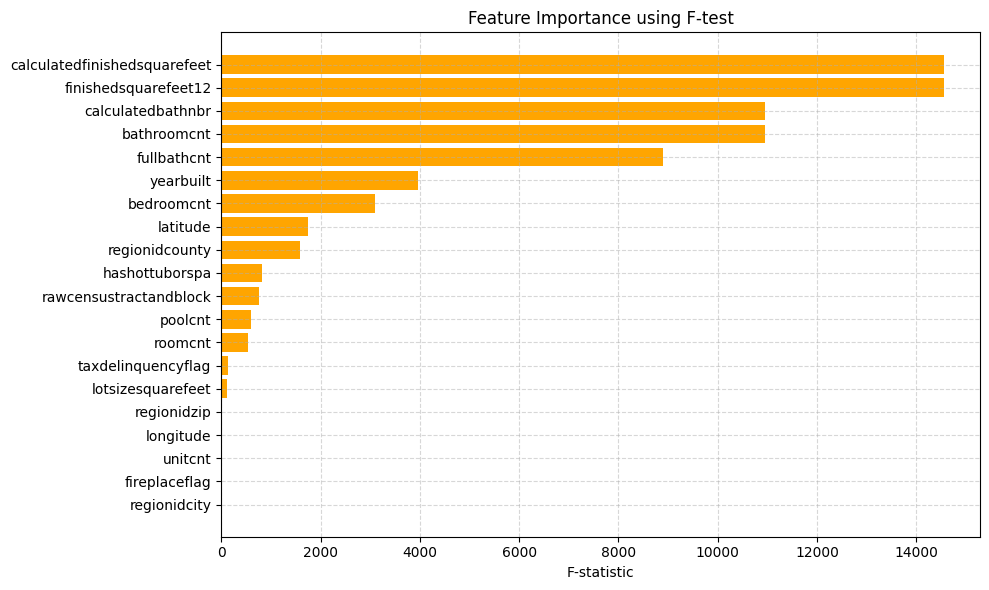

In [120]:
#Compute F statistics 

#Here we have considered only the numeric columns for the sake of ease and processing

X = df_clean_numeric.drop(columns='taxvaluedollarcnt')
y = df_clean_numeric['taxvaluedollarcnt']

selector = SelectKBest(score_func=f_regression, k='all')  # Use 'all' to get scores for all features
selector.fit(X, y)

f_scores = selector.scores_
p_values = selector.pvalues_

# Put into a DataFrame
f_stats_df = pd.DataFrame({
    'Feature': X.columns,
    'F_statistic': f_scores,
    'p_value': p_values
}).sort_values(by='F_statistic', ascending=False)

# Plot the F-statistics
plt.figure(figsize=(10, 6))
plt.barh(f_stats_df['Feature'], f_stats_df['F_statistic'], color='orange')
plt.xlabel("F-statistic")
plt.title("Feature Importance using F-test")
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()


In [121]:
# exclude features with low f-stats for the following feature selection run
X_col = X.drop(columns=["regionidzip","longitude","unitcnt","fireplaceflag","regionidcity"])

In [ ]:
# Forward feature selection function

def forward_feature_selection(X, y, model, 
                              scoring='neg_mean_squared_error', 
                              cv=3, 
                              tol=None,              
                              max_features=len(X.columns),      
                              n_jobs=-1,
                              verbose=True):
    
    selected_features = []
    remaining_features = list(X.columns)
    best_scores = []
    previous_score = float('inf')
    
    model = RandomForestRegressor()  
    
    best_forward_features = None
    best_score = float('inf')
    
    while remaining_features:
        scores = {}
        for feature in remaining_features:
            current_features = selected_features + [feature]
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
            scores[feature] = cv_score

        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]

        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"Features: {selected_features}, CV Score (MSE): {current_score:.4f}")

        if current_score < best_score:
            best_score = current_score
            best_forward_features = selected_features.copy()

        if max_features is not None and len(selected_features) >= max_features:
            break

    return selected_features, best_scores, best_forward_features, best_score


Features: ['rawcensustractandblock'], CV Score (MSE): 35382611475.4784
Features: ['rawcensustractandblock', 'bathroomcnt'], CV Score (MSE): 30779226679.9164
Features: ['rawcensustractandblock', 'bathroomcnt', 'roomcnt'], CV Score (MSE): 30736452793.1843
Features: ['rawcensustractandblock', 'bathroomcnt', 'roomcnt', 'regionidcounty'], CV Score (MSE): 30725749346.0079
Features: ['rawcensustractandblock', 'bathroomcnt', 'roomcnt', 'regionidcounty', 'fullbathcnt'], CV Score (MSE): 30733216124.8901
Features: ['rawcensustractandblock', 'bathroomcnt', 'roomcnt', 'regionidcounty', 'fullbathcnt', 'calculatedbathnbr'], CV Score (MSE): 30748435881.6623
Features: ['rawcensustractandblock', 'bathroomcnt', 'roomcnt', 'regionidcounty', 'fullbathcnt', 'calculatedbathnbr', 'hashottuborspa'], CV Score (MSE): 30769381286.2629
Features: ['rawcensustractandblock', 'bathroomcnt', 'roomcnt', 'regionidcounty', 'fullbathcnt', 'calculatedbathnbr', 'hashottuborspa', 'taxdelinquencyflag'], CV Score (MSE): 3105041

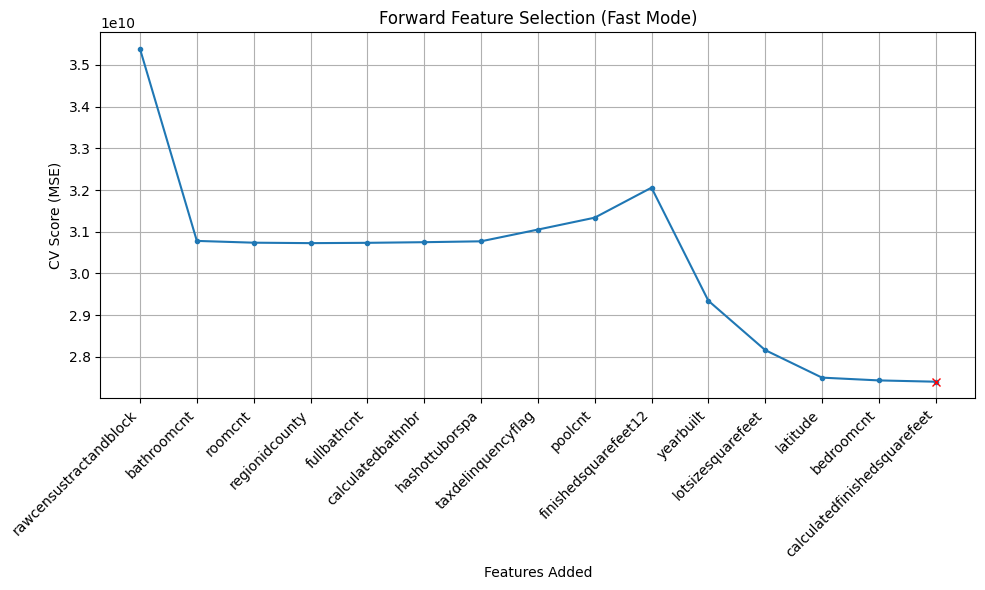

Best Features: ['rawcensustractandblock', 'bathroomcnt', 'roomcnt', 'regionidcounty', 'fullbathcnt', 'calculatedbathnbr', 'hashottuborspa', 'taxdelinquencyflag', 'poolcnt', 'finishedsquarefeet12', 'yearbuilt', 'lotsizesquarefeet', 'latitude', 'bedroomcnt', 'calculatedfinishedsquarefeet']


In [44]:

selected_features, best_scores, best_forward_features, best_score = forward_feature_selection(X_col, y, model=None)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_scores) + 1), best_scores, marker='.')
plt.plot([len(best_forward_features)], [best_score], marker='x', color='red')
plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=45, ha='right')
plt.title('Forward Feature Selection (Fast Mode)')
plt.xlabel('Features Added')
plt.ylabel('CV Score (MSE)')
plt.grid()
plt.tight_layout()
plt.show()

print(f"Best Features: {best_forward_features}")


In [117]:
def backward_feature_selection(X, y, model=None, 
                               scoring='neg_mean_squared_error', 
                               cv=3, 
                               tol=None, 
                               min_features=3,      
                               n_jobs=-1,
                               verbose=True):

    remaining_features = list(X.columns)
    best_scores = []
    removed_features = []  # Track features in removal order
    previous_score = float('inf')

    if model is None:
        model = RandomForestRegressor()

    best_backward_features = remaining_features.copy()
    best_score = float('inf')

    while len(remaining_features) > min_features:
        scores = {}

        for feature in remaining_features:
            current_features = [f for f in remaining_features if f != feature]
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
            scores[feature] = cv_score

        worst_feature = min(scores, key=scores.get)
        current_score = scores[worst_feature]

        # Stop if improvement is too small
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        removed_features.append(worst_feature)  # Track removed feature
        remaining_features.remove(worst_feature)
        best_scores.append(current_score)
        previous_score = current_score

        if verbose:
            print(f"Removed: {worst_feature}, Features left: {remaining_features}, MSE: {current_score:.4f}")

        if current_score < best_score:
            best_score = current_score
            best_backward_features = remaining_features.copy()

    return removed_features, best_scores, best_backward_features, best_score


In [122]:
removed_features, best_scores, best_backward_features, best_score = backward_feature_selection(X_col, y)

Removed: calculatedbathnbr, Features left: ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt', 'hashottuborspa', 'latitude', 'lotsizesquarefeet', 'poolcnt', 'rawcensustractandblock', 'regionidcounty', 'roomcnt', 'yearbuilt', 'taxdelinquencyflag'], MSE: 27404356977.2560


/home/codespace/.local/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Removed: fullbathcnt, Features left: ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'hashottuborspa', 'latitude', 'lotsizesquarefeet', 'poolcnt', 'rawcensustractandblock', 'regionidcounty', 'roomcnt', 'yearbuilt', 'taxdelinquencyflag'], MSE: 27411491509.1445
Removed: calculatedfinishedsquarefeet, Features left: ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'hashottuborspa', 'latitude', 'lotsizesquarefeet', 'poolcnt', 'rawcensustractandblock', 'regionidcounty', 'roomcnt', 'yearbuilt', 'taxdelinquencyflag'], MSE: 27390450832.6110
Removed: regionidcounty, Features left: ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'hashottuborspa', 'latitude', 'lotsizesquarefeet', 'poolcnt', 'rawcensustractandblock', 'roomcnt', 'yearbuilt', 'taxdelinquencyflag'], MSE: 27392788928.6310
Removed: taxdelinquencyflag, Features left: ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'hashottuborspa', 'latitude', 'lotsizesquarefeet', 'poolcnt', 'rawcens

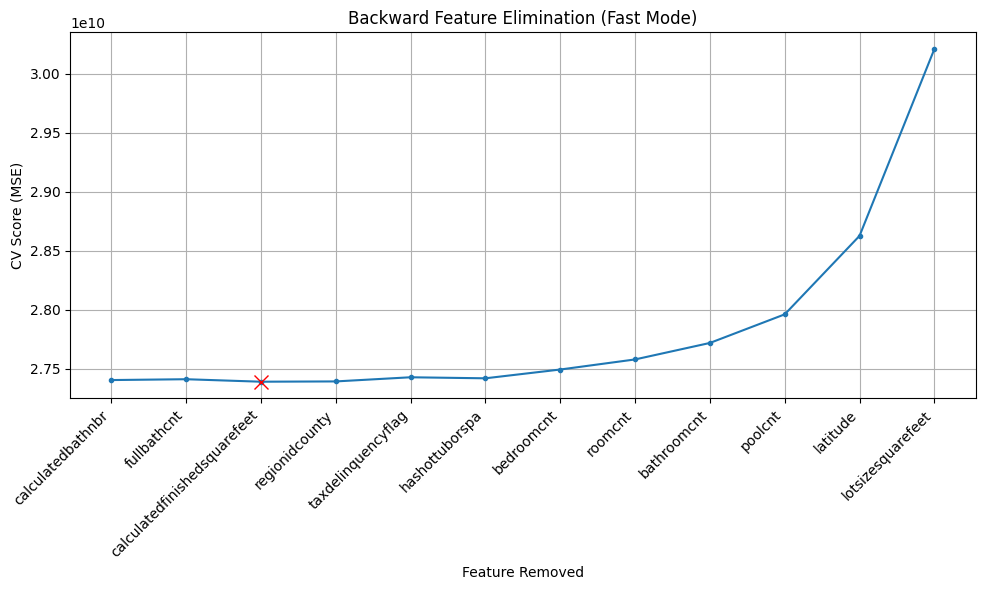

In [132]:
best_score_index = best_scores.index(best_score)
best_removed_feature = removed_features[best_score_index]  # Feature removed at best score


plt.figure(figsize=(10, 6))
plt.plot(range(len(best_scores)), best_scores, marker='.', label='MSE scores')

plt.plot(best_score_index, best_score, 
         marker='x', color='red', markersize=10, label=f"Best ({best_removed_feature})")

plt.xticks(range(len(removed_features)), removed_features, rotation=45, ha='right')
plt.title('Backward Feature Elimination (Fast Mode)')
plt.xlabel('Feature Removed')
plt.ylabel('CV Score (MSE)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [139]:
print(f"Best Features: {best_backward_features}") 

Best Features: ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'hashottuborspa', 'latitude', 'lotsizesquarefeet', 'poolcnt', 'rawcensustractandblock', 'regionidcounty', 'roomcnt', 'yearbuilt', 'taxdelinquencyflag']


#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

Below 3 pairs of features seem interesting as per the correlation and F statistics analysis:

1. bathroomcnt vs finishedsquarefeet12: Strong correlation (≈ 0.73) and both are highly ranked in F-statistics.  Likely shows that larger homes tend to have more bathrooms 

2. calculatedfinishedsquarefeet vs bedroomcnt: high correlation (~0.68) and both are among the top 8 in F-stat ranking. We’d expect a positive trend — homes with more bedrooms are generally larger.

3. roomcnt vs rawcensustractandblock:  Correlation ~0.71, this one's interesting because it ties a property characteristic (roomcnt) to a location-based feature. Could indicate certain geographic areas have consistently larger or smaller homes — this might hint at neighborhood-level effects.



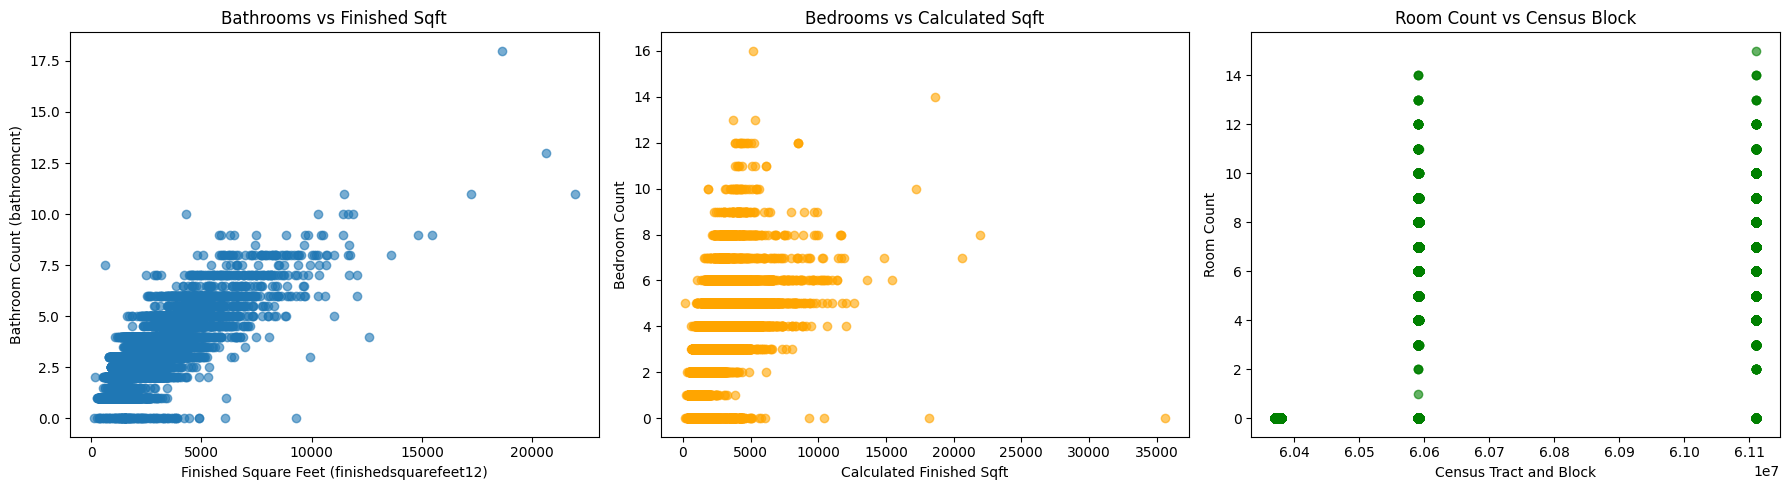

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: bathroomcnt vs finishedsquarefeet12
axs[0].scatter(df['finishedsquarefeet12'], df['bathroomcnt'], alpha=0.6)
axs[0].set_xlabel("Finished Square Feet (finishedsquarefeet12)")
axs[0].set_ylabel("Bathroom Count (bathroomcnt)")
axs[0].set_title("Bathrooms vs Finished Sqft")

# Plot 2: calculatedfinishedsquarefeet vs bedroomcnt
axs[1].scatter(df['calculatedfinishedsquarefeet'], df['bedroomcnt'], alpha=0.6, color='orange')
axs[1].set_xlabel("Calculated Finished Sqft")
axs[1].set_ylabel("Bedroom Count")
axs[1].set_title("Bedrooms vs Calculated Sqft")

# Plot 3: rawcensustractandblock vs roomcnt
axs[2].scatter(df['rawcensustractandblock'], df['roomcnt'], alpha=0.6, color='green')
axs[2].set_xlabel("Census Tract and Block")
axs[2].set_ylabel("Room Count")
axs[2].set_title("Room Count vs Census Block")

plt.tight_layout()
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


1. Bathrooms vs Finished Square Feet: There’s a strong upward linear relationship. Homes with more finished square footage tend to have more bathrooms. This aligns with expectations—larger homes are generally equipped with more bathrooms to accommodate their size and occupancy.


2. Bedrooms vs Calculated Finished Square Feet: There is positive correlation with some variability. As the calculated finished area increases, the number of bedrooms also tends to increase. However, the spread suggests diminishing returns beyond a certain point, where larger homes may prioritize other amenities over simply adding bedrooms.


3. Room Count vs Census Tract and Block: There are vertical clustering patterns. While the room count doesn't show a strong continuous trend with census blocks, certain tracts seem to have properties with similar room counts, possibly indicating development standards within specific regions.

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

In [27]:
df_clean

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,hashottuborspa,latitude,longitude,lotsizesquarefeet,...,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,fireplaceflag,taxdelinquencyflag,taxvaluedollarcnt
1,1.0,2.0,1.0,1465.0,1465.0,1.0,0,34449266.0,-119281531.0,12647.0,...,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,0,0,464000.0
2,2.0,3.0,2.0,1243.0,1243.0,2.0,0,33886168.0,-117823170.0,8432.0,...,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,0,0,564778.0
3,3.0,4.0,3.0,2376.0,2376.0,3.0,0,34245180.0,-118240722.0,13038.0,...,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,0,0,145143.0
4,3.0,3.0,3.0,1312.0,1312.0,3.0,0,34185120.0,-118414640.0,278581.0,...,6.037124e+07,12447.0,3101.0,96451.0,0.0,1.0,1964.0,0,0,119407.0
5,2.0,3.0,2.0,1492.0,1492.0,2.0,0,34230044.0,-118993991.0,903.0,...,6.111005e+07,51239.0,2061.0,97091.0,6.0,1.0,1982.0,0,0,331064.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,3.0,3.0,3.0,1741.0,1741.0,3.0,0,34202400.0,-118502000.0,59487.0,...,6.037132e+07,12447.0,3101.0,96415.0,0.0,1.0,1980.0,0,0,379000.0
77609,2.0,2.0,2.0,1286.0,1286.0,2.0,0,34245368.0,-118282383.0,47405.0,...,6.037101e+07,12447.0,3101.0,96284.0,0.0,1.0,1940.0,0,0,354621.0
77610,2.0,4.0,2.0,1612.0,1612.0,2.0,0,34300140.0,-118706327.0,12105.0,...,6.111008e+07,27110.0,2061.0,97116.0,7.0,1.0,1964.0,0,0,67205.0
77611,1.0,3.0,1.0,1032.0,1032.0,1.0,0,34040895.0,-118038169.0,5074.0,...,6.037434e+07,36502.0,3101.0,96480.0,0.0,1.0,1954.0,0,0,49546.0


In [28]:
#target variable is taxvaluedollarcnt (regression)
X = df_clean.drop(columns=["taxvaluedollarcnt"])
y = df_clean["taxvaluedollarcnt"]


**why did I choose this as target variable?**
- Continuous numeric variable: It's a regression-friendly variable — not a category or a binary flag.
- Important outcome: Property value is central in real estate and tax analysis, making it meaningful for stakeholders (buyers, assessors, analysts).
- Predictive goal: Many machine learning or statistical models aim to estimate or predict home values, which makes this a practical modeling target.
- Other features are predictors: Variables like bathroomcnt, bedroomcnt, lotsizesquarefeet, and yearbuilt are descriptive features that logically influence value — so they are inputs rather than outcomes.

- Skewness: Identifies which features may benefit from a log transform.
- Correlation with the target (taxvaluedollarcnt): Reveals linear relationships.
- F-score (from SelectKBest): Shows how predictive each feature is individually

In [29]:
#Check skewness for log transformation
skewness = X.skew().sort_values(ascending=False)
print(skewness)

regionidzip                     101.119921
unitcnt                         100.167314
lotsizesquarefeet                26.234748
fireplaceflag                    19.793693
hashottuborspa                    8.979532
regionidcity                      6.369493
taxdelinquencyflag                5.021096
rawcensustractandblock            2.030000
poolcnt                           1.539747
roomcnt                           1.413273
finishedsquarefeet12              1.398504
calculatedfinishedsquarefeet      1.398504
fullbathcnt                       0.584252
bathroomcnt                       0.470274
calculatedbathnbr                 0.470274
latitude                          0.320073
bedroomcnt                        0.228190
yearbuilt                        -0.315357
longitude                        -0.716775
regionidcounty                   -0.759520
dtype: float64


In [30]:
 #Compute correlation with target
correlation = df_clean.corr(numeric_only=True)["taxvaluedollarcnt"].sort_values(ascending=False)
print(correlation)

taxvaluedollarcnt               1.000000
calculatedfinishedsquarefeet    0.427379
finishedsquarefeet12            0.427379
calculatedbathnbr               0.379457
bathroomcnt                     0.379457
fullbathcnt                     0.346662
yearbuilt                       0.239679
bedroomcnt                      0.212778
hashottuborspa                  0.112186
rawcensustractandblock          0.108022
poolcnt                         0.095448
roomcnt                         0.090201
regionidzip                     0.006530
longitude                       0.006055
unitcnt                         0.003041
fireplaceflag                   0.001981
regionidcity                    0.000234
lotsizesquarefeet              -0.042433
taxdelinquencyflag             -0.044797
regionidcounty                 -0.153990
latitude                       -0.161881
Name: taxvaluedollarcnt, dtype: float64


In [31]:
#Baseline feature importance using F-score
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)
f_scores = pd.Series(selector.scores_, index=X.columns).sort_values(ascending=False)
print(f_scores)

calculatedfinishedsquarefeet    14555.776701
finishedsquarefeet12            14555.776701
calculatedbathnbr               10956.159248
bathroomcnt                     10956.159248
fullbathcnt                      8896.751732
yearbuilt                        3969.808424
bedroomcnt                       3088.784486
latitude                         1752.817756
regionidcounty                   1582.063237
hashottuborspa                    830.216296
rawcensustractandblock            769.015877
poolcnt                           598.854928
roomcnt                           534.296153
taxdelinquencyflag                130.976024
lotsizesquarefeet                 117.489071
regionidzip                         2.777428
longitude                           2.388410
unitcnt                             0.602324
fireplaceflag                       0.255664
regionidcity                        0.003559
dtype: float64


In [32]:
# apply results into DF
feature_stats = pd.DataFrame({
    "Skewness": skewness,
    "Correlation": correlation.drop("taxvaluedollarcnt", errors='ignore'),
    "F-score": f_scores
})

print(feature_stats)

                                Skewness  Correlation       F-score
bathroomcnt                     0.470274     0.379457  10956.159248
bedroomcnt                      0.228190     0.212778   3088.784486
calculatedbathnbr               0.470274     0.379457  10956.159248
calculatedfinishedsquarefeet    1.398504     0.427379  14555.776701
finishedsquarefeet12            1.398504     0.427379  14555.776701
fireplaceflag                  19.793693     0.001981      0.255664
fullbathcnt                     0.584252     0.346662   8896.751732
hashottuborspa                  8.979532     0.112186    830.216296
latitude                        0.320073    -0.161881   1752.817756
longitude                      -0.716775     0.006055      2.388410
lotsizesquarefeet              26.234748    -0.042433    117.489071
poolcnt                         1.539747     0.095448    598.854928
rawcensustractandblock          2.030000     0.108022    769.015877
regionidcity                    6.369493     0.0

#### 3 transormations to try (feature scaling, log transformation, and polynomial features

In [33]:
from sklearn.preprocessing import StandardScaler
#Scaling
# Step 1: Separate features and target
X_std = df_clean.drop(columns=["taxvaluedollarcnt"])
y = df_clean["taxvaluedollarcnt"]

# Step 2: Apply Standard Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_std)

# Step 3: Convert back to DataFrame for inspection
X_scaled_df = pd.DataFrame(X_scaled, columns=X_std.columns)

# Show summary statistics to confirm mean ≈ 0 and std ≈ 1
X_scaled_df.describe().loc[["mean", "std"]]


,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,fireplaceflag,taxdelinquencyflag
mean,-1.919885e-17,4.581543e-18,-1.919885e-17,8.934008e-17,8.934008e-17,-5.988731e-17,-2.116236e-17,4.031758e-16,-9.540081e-15,-5.454218e-18,-1.614448e-17,-4.074519e-15,7.810440e-17,1.134477e-16,-2.455161e-15,-1.570815e-17,9.248171e-16,-4.837236e-15,2.618024e-17,3.927037e-17
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00


In [34]:
#log transformation
# Step 1: Identify skewed features (skewness > 1)
skewed_features = X_std.skew()
skewed_cols = skewed_features[skewed_features > 1].index.tolist()

# Step 2: Apply log1p transformation
X_log = X_std.copy()
X_log[skewed_cols] = np.log1p(X_log[skewed_cols])

# Step 3: Check updated skewness and F-scores
new_skewness = X_log.skew()
selector_log = SelectKBest(score_func=f_regression, k='all')
selector_log.fit(X_log, y)
log_f_scores = pd.Series(selector_log.scores_, index=X_log.columns)

# Combine results for transformed features
log_feature_stats = pd.DataFrame({
    "Original Skew": skewed_features[skewed_cols],
    "New Skew": new_skewness[skewed_cols],
    "F-score after Log": log_f_scores[skewed_cols]
})
print(log_feature_stats)

                              Original Skew   New Skew  F-score after Log
calculatedfinishedsquarefeet       1.398504   0.097395       14454.649823
finishedsquarefeet12               1.398504   0.097395       14454.649823
hashottuborspa                     8.979532   8.979532         830.216296
lotsizesquarefeet                 26.234748   1.813021          65.499491
poolcnt                            1.539747   1.539747         598.854928
rawcensustractandblock             2.030000   2.023954         771.930430
regionidcity                       6.369493   0.525413         145.931470
regionidzip                      101.119921  90.566101           2.983387
roomcnt                            1.413273   1.238774         296.161510
unitcnt                          100.167314  71.980115           1.435545
fireplaceflag                     19.793693  19.793693           0.255664
taxdelinquencyflag                 5.021096   5.021096         130.976024


In [35]:
# polynomial transformation
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest

# Step 1: Select top 3 features based on correlation with target
top_features = correlation.drop("taxvaluedollarcnt").nlargest(3).index.tolist()

# Step 2: Generate polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_std[top_features])

# Get new feature names for interpretation
poly_feature_names = poly.get_feature_names_out(top_features)

# Step 3: Evaluate with F-score
selector_poly = SelectKBest(score_func=f_regression, k='all')
selector_poly.fit(X_poly, y)
poly_f_scores = pd.Series(selector_poly.scores_, index=poly_feature_names).sort_values(ascending=False)

# Display top polynomial terms
top_poly_features = poly_f_scores.head(10).to_frame(name="F-score")
print(top_poly_features)

                                                        F-score
calculatedfinishedsquarefeet                       14555.776701
finishedsquarefeet12                               14555.776701
calculatedfinishedsquarefeet calculatedbathnbr     13393.549904
finishedsquarefeet12 calculatedbathnbr             13393.549904
calculatedfinishedsquarefeet^2                     11650.394685
finishedsquarefeet12^2                             11650.394685
calculatedfinishedsquarefeet finishedsquarefeet12  11650.394685
calculatedbathnbr                                  10956.159248
calculatedbathnbr^2                                10125.645501


#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


I chose three transformations—standard scaling, log transformation, and polynomial features—to explore a diverse set of feature engineering techniques that are commonly useful for a linear model.  Standard scaling was applied to normalize the range of features, which is important for distance-based algorithms and improves interpretability for linear models. Log transformation targeted skewed features like lotsizesquarefeet and regionidcity, significantly reducing skewness and improving their linear relationship with the target variable. Lastly, polynomial features were used to capture potential non-linear relationships and interactions between key predictors such as bathroomcnt and finishedsquarefeet12. These transformations improved individual feature scores (F-scores) and correlations, suggesting they could enhance model performance.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

